In [ ]:
import torch
from hydra import compose, initialize
from hydra.utils import instantiate
from metalearning_benchmarks import MetaLearningBenchmark
from torch.utils.data import DataLoader

from src.context_datasets import MetaLearningDataset
from src.control_function import ControlFunction
from src.decoder import Decoder
from src.dvi_process import DiffusionVIProcess
from src.encoder import SetEncoder
from src.visualize import visualize

In [2]:
try:
    import torch_directml
    device = torch_directml.device() 
except ImportError:
    device = torch.device("cpu") 
print(device)

privateuseone:0


In [3]:
dir = f"../models/laced-water-57"

In [ ]:
with initialize(version_base=None, config_path=dir):
    config = compose(config_name="config")

    benchmark: MetaLearningBenchmark = instantiate(config.benchmark.value)
    dataset = MetaLearningDataset(benchmark=benchmark)
    dataloader = DataLoader(dataset=dataset, batch_size=1, shuffle=True)

    set_encoder = SetEncoder(
        c_dim=config.common.value.c_dim,
        h_dim=config.common.value.h_dim,
        num_layers=config.common.value.num_layers,
        non_linearity=config.common.value.non_linearity,
        is_attentive=config.set_encoder.value.is_attentive,
        is_aggregative=not config.control_function.value.is_cross_attentive
        or not config.decoder.value.is_cross_attentive,
        is_non_aggregative=config.control_function.value.is_cross_attentive
        or config.decoder.value.is_cross_attentive,
        use_context_size=config.set_encoder.value.use_context_size,
        aggregation=config.set_encoder.value.aggregation,
        max_context_size=dataset.max_context_size,
    ).to(device)

    control_function = ControlFunction(
        h_dim=config.common.value.h_dim,
        z_dim=config.common.value.z_dim,
        num_layers=config.common.value.num_layers,
        non_linearity=config.common.value.non_linearity,
        num_steps=config.dvi_process.value.num_steps,
        is_cross_attentive=config.control_function.value.is_cross_attentive,
    ).to(device)

    dvi_process: DiffusionVIProcess = instantiate(
        config.dvi_process.value,
        z_dim=config.common.value.z_dim,
        control_function=control_function,
        device=device,
    )

    decoder = Decoder(
        x_dim=config.common.value.x_dim,
        z_dim=config.common.value.z_dim,
        h_dim=config.common.value.h_dim,
        y_dim=config.common.value.y_dim,
        num_layers=config.common.value.num_layers,
        non_linearity=config.common.value.non_linearity,
        has_lat_path=config.decoder.value.has_lat_path,
        has_det_path=config.decoder.value.has_det_path,
        is_cross_attentive=config.decoder.value.is_cross_attentive,
    ).to(device)

    set_encoder.load_state_dict(torch.load(f"{dir}/set_encoder.pth", map_location=torch.device("cpu"), weights_only=True))
    dvi_process.load_state_dict(torch.load(f"{dir}/dvi_process.pth", map_location=torch.device("cpu"), weights_only=True))
    decoder.load_state_dict(torch.load(f"{dir}/decoder.pth", map_location=torch.device("cpu"), weights_only=True))

Generating tasks: 100%|██████████| 4096/4096 [00:00<00:00, 258697.91it/s]


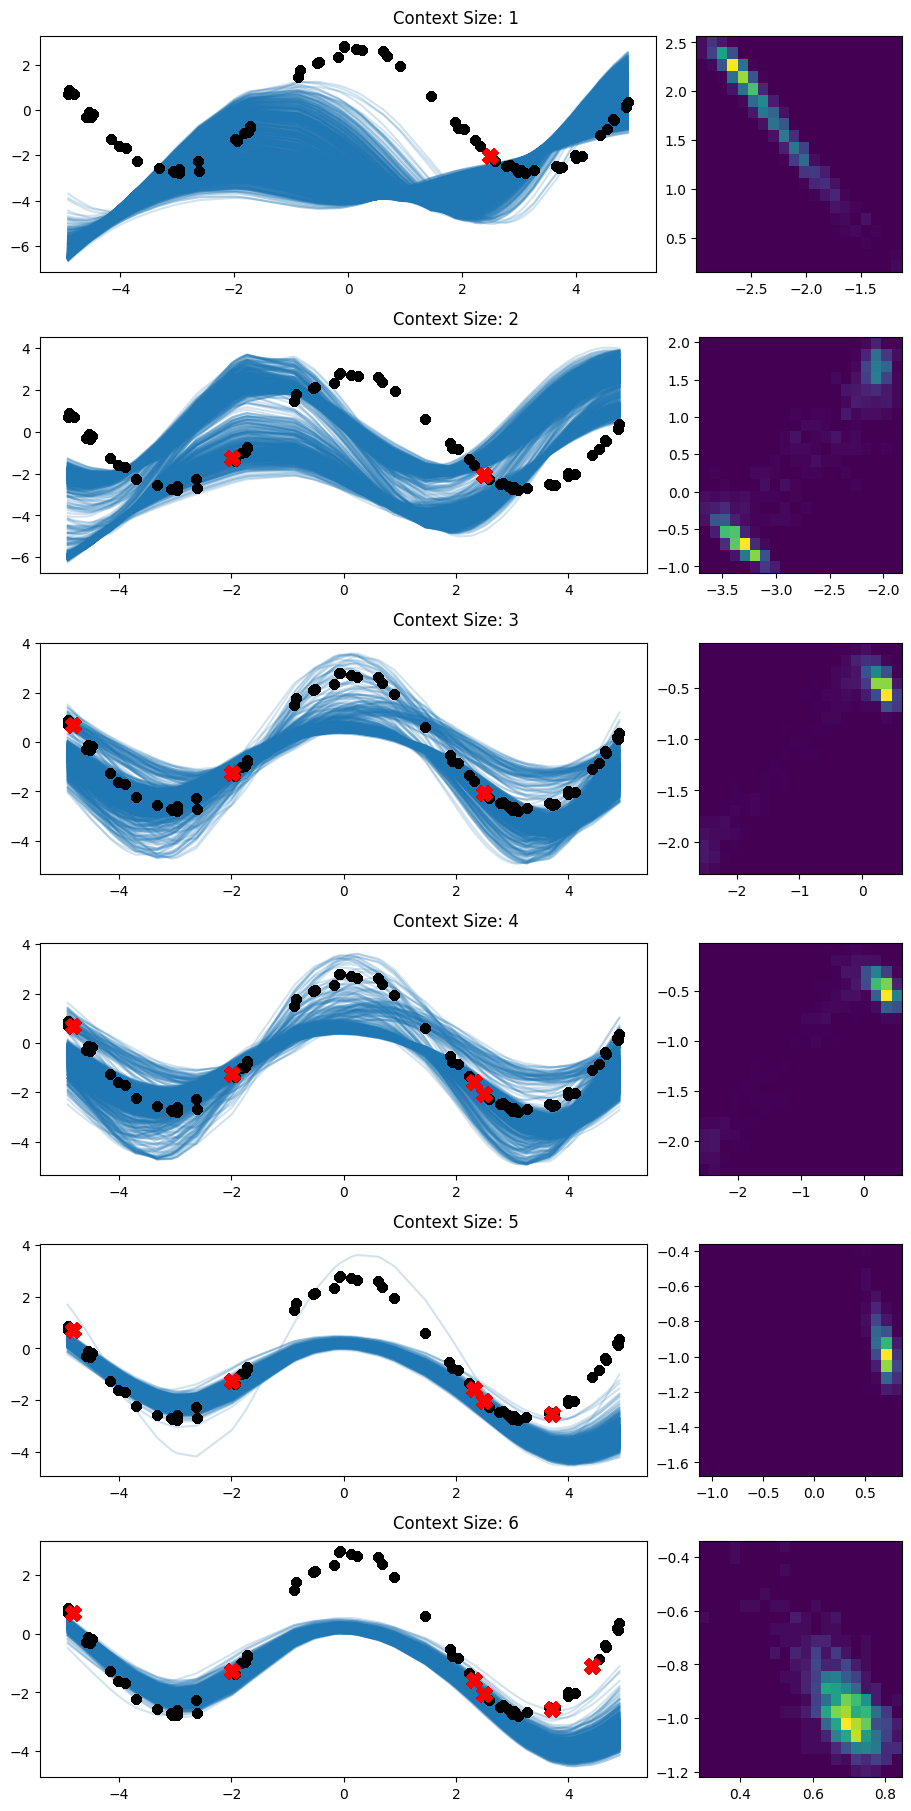

In [17]:
max_context_size = 6
num_samples = 1024

visualize(
    device=device,
    dvi_process=dvi_process,
    set_encoder=set_encoder,
    decoder=decoder,
    dataloader=dataloader,
    control_function=control_function,
    config=config,
    num_samples=num_samples,
    max_context_size=max_context_size
)